<a href="https://colab.research.google.com/github/Loyloyy/XGBoost-/blob/master/XGBoost_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Guide on tuning parameters for XGBoost
 This guide is to help me and any others learn on how easy it can be to actually tune XGBoost and see how powerful this algorithm can be as well. 

 Most of the guide and code here ahs been forked from this article:
 https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

 The code has been tweaked to correct parameters and that has been changed as well as of 2020.

In [0]:
#Import relevant libraries in
import io
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import cross_validate   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

Then we import the dataset in

In [0]:
from google.colab import files
uploaded = files.upload()

Saving train_modified.csv to train_modified.csv


In [0]:
train = pd.read_csv(io.BytesIO(uploaded['train_modified.csv']))

As shown at the top, 2 forms of XGBoost were imported

"import xgboost as xgb" - This is the direct xgboost library. and it will mainly be used for it's cross validation function

"XGBClassifier" – This is the sklearn wrapper for XGBoost. This will allow us to use Sklearn’s Grid Search with parallel processing.

Before proceeding further, lets define a function which will help us create XGBoost models and perform cross-validation.

In [0]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=None)
        alg.set_params(n_estimators=cvresult.shape[0])

    print(cvresult)
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    print("Best Iteration: {}".format(alg.get_booster().best_iteration))
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


#General Parameters
These define the overall functionality of XGBoost. 

1.   Booster [default=gbtree]
      *   gbtree or dart: Tree-based mode
      *   gblinear: Linear models

2.   verbosity [default=1]
      *   Verbosity of printing messages. Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). Sometimes XGBoost tries to change configurations based on heuristics, which is displayed as warning message. If there’s unexpected behaviour, please try to increase value of verbosity.
      *   It’s generally good to keep it 1 as the messages might help in understanding the model.

3.   nthread [default to maximum number of threads available if not set]
    *   This is used for parallel processing and number of cores in the system should be entered
    *   If you wish to run on all cores, value should not be entered and algorithm will detect automatically

There are also several other features but we will not be using them here.

Other parameters include:
*   validate_parameters [still experimental and may give false positives]
*   disable_default_eval_metric [flag to disable default metric]
*   num_pbuffer [size of prediction bugger which is set automatically by XGBoost]
*   num_feature [feature dimension used in boosting which is also set automatically by XGBoost]

#Parameters for Tree Booster
The parameters for tuning the tree can be found over at https://xgboost.readthedocs.io/en/latest/parameter.html

#First Step
Before deciding on boosting parameters, the other parameters will need to be set as well
Here in this section, we shall set some initial values for the other parameters

The code below shows initial parameters for xgb1. The result will the incate to us which was the best iteration. From there, we can then set the number of estimators (n_estimators) accordingly.

In [0]:
target = 'Disbursed'
IDcol = 'ID'
predictors = [x for x in train.columns if x not in [target, IDcol]]

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

predictors
#Using modelfit function to then find the best number of estimators
#modelfit(xgb1, train, predictors)

['Existing_EMI',
 'Loan_Amount_Applied',
 'Loan_Tenure_Applied',
 'Monthly_Income',
 'Var4',
 'Var5',
 'Age',
 'EMI_Loan_Submitted_Missing',
 'Interest_Rate_Missing',
 'Loan_Amount_Submitted_Missing',
 'Loan_Tenure_Submitted_Missing',
 'Processing_Fee_Missing',
 'Device_Type_0',
 'Device_Type_1',
 'Filled_Form_0',
 'Filled_Form_1',
 'Gender_0',
 'Gender_1',
 'Var1_0',
 'Var1_1',
 'Var1_2',
 'Var1_3',
 'Var1_4',
 'Var1_5',
 'Var1_6',
 'Var1_7',
 'Var1_8',
 'Var1_9',
 'Var1_10',
 'Var1_11',
 'Var1_12',
 'Var1_13',
 'Var1_14',
 'Var1_15',
 'Var1_16',
 'Var1_17',
 'Var1_18',
 'Var2_0',
 'Var2_1',
 'Var2_2',
 'Var2_3',
 'Var2_4',
 'Var2_5',
 'Var2_6',
 'Mobile_Verified_0',
 'Mobile_Verified_1',
 'Source_0',
 'Source_1',
 'Source_2']

The out put indicated that the best estimation paramter is 133. 

As this can be computatinally expensive, an alternative will be to increase the learning rate to get a reduced number of estimators so as to save time for the following procedures below.

#Second Step
Second step will be to tune the max_depth and min_child_weight

The reason for tuning these first is because they will have the highest impact on model outcome.
As this part utilises grid search, it can take quite a while to give a result as well

Do remember to change the n_estimators parameter accordingly too!

In [0]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=133, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
print(gsearch1.cv_results_)
print(gsearch1.best_params_)
print(gsearch1.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([ 38.3097065 ,  39.42574406,  37.27901196,  58.5935595 ,
        58.09961457,  57.86428876,  81.24918909,  80.34294047,
        80.92614975, 106.71497626, 102.74040389,  90.81709676]), 'std_fit_time': array([1.30651632, 1.71842824, 0.23531414, 0.36246008, 0.427661  ,
       0.3169655 , 0.97604646, 0.57534905, 1.83158634, 1.74656595,
       1.15708048, 9.68297721]), 'mean_score_time': array([0.25914369, 0.23789883, 0.22295504, 0.31896167, 0.32163358,
       0.4019846 , 0.44134588, 0.44384203, 0.45587711, 0.57550082,
       0.52925253, 0.36471925]), 'std_score_time': array([0.0630135 , 0.04447037, 0.06010633, 0.06638953, 0.05170725,
       0.03647845, 0.04260678, 0.03596588, 0.03853369, 0.07431987,
       0.06763627, 0.18209949]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtyp

From the above, 9 combinations have been ran with wider intervals between values. The ideal values are 5 for max_depth and 1 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

Hence, for "max_depth", as the previous result was 5, we shall use 4, 5 and 6 now. While for "min_child_weight", as the previous result was 1, we shall find 1, 2, 3.

Do remember to change the max_depth and min_child_weight parameters accordingly too!

In [0]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=133, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
print(gsearch2.cv_results_)
print(gsearch2.best_params_)
print(gsearch2.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([47.44180226, 47.17277865, 47.20586839, 58.4891499 , 58.10971279,
       57.90734792, 69.31232038, 69.09539423, 58.06259532]), 'std_fit_time': array([ 0.28495625,  0.32296626,  0.41079082,  0.36323216,  0.17559545,
        0.38005227,  0.74749787,  0.5116026 , 15.4600477 ]), 'mean_score_time': array([0.27078028, 0.28350501, 0.2520546 , 0.34619174, 0.35981002,
       0.35046659, 0.39626074, 0.38930922, 0.26457105]), 'std_score_time': array([0.05542988, 0.06303022, 0.06043794, 0.05946254, 0.05416371,
       0.0580182 , 0.06866352, 0.01096199, 0.13498545]), 'param_max_depth': masked_array(data=[4, 4, 4, 5, 5, 5, 6, 6, 6],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_min_child_weight': masked_array(data=[1, 2, 3, 1, 2, 3, 1, 2, 3],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',

The result was still the same and we can conlcude that these figures are the most appropiate for the current problem.

However as the min_child_weight is still at the lowest, we can go even further to see if we can take another step deeper to look for more optimum values.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.788783       0.005993       0.785430      0.017835
1          0.802262       0.007334       0.794420      0.015611
2          0.810138       0.005614       0.800453      0.019180
3          0.816026       0.006358       0.805943      0.019725
4          0.822108       0.004766       0.809853      0.019539
..              ...            ...            ...           ...
135        0.910998       0.003173       0.843494      0.014412
136        0.911297       0.003173       0.843355      0.014433
137        0.911797       0.003209       0.843487      0.014405
138        0.912131       0.003223       0.843347      0.014347
139        0.912442       0.003192       0.843338      0.014417

[140 rows x 4 columns]

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.901530
Best Iteration: 139


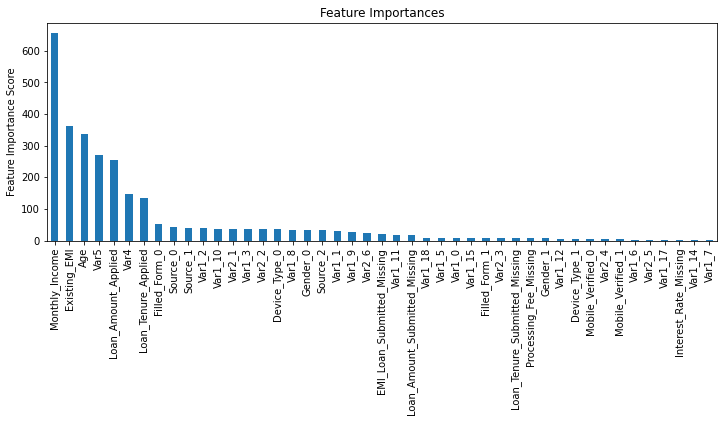

{'mean_fit_time': array([61.35651336, 61.22272773, 51.990587  ]), 'std_fit_time': array([0.31531938, 0.41557154, 7.36085565]), 'mean_score_time': array([0.36071649, 0.29994755, 0.26255245]), 'std_score_time': array([0.08604527, 0.03833444, 0.10072579]), 'param_min_child_weight': masked_array(data=[0.5, 1, 1.5],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'min_child_weight': 0.5}, {'min_child_weight': 1}, {'min_child_weight': 1.5}], 'split0_test_score': array([0.83492092, 0.83216203, 0.83103912]), 'split1_test_score': array([0.83451149, 0.83491414, 0.83423555]), 'split2_test_score': array([0.84882683, 0.84865761, 0.8492604 ]), 'split3_test_score': array([0.84795215, 0.85054271, 0.84789795]), 'split4_test_score': array([0.83983323, 0.83950782, 0.84263097]), 'mean_test_score': array([0.84120892, 0.84115686, 0.8410128 ]), 'std_test_score': array([0.00616102, 0.00730689, 0.00725882]), 'rank_test_score': array([1, 2, 3], dtype=int32)

In [0]:
param_test2b = {'min_child_weight':[0.5,1,1.5]}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

modelfit(gsearch2b.best_estimator_, train, predictors)
print(gsearch2b.cv_results_)
print(gsearch2b.best_params_)
print(gsearch2b.best_score_)

From this result, we can see that 0.5 is a better setting for the parameter of min_child_weight instead.

#Step 3: Tune gamma

Next up, we shall be tuning the gamma value along with parameters we got the results above. We will check for 5 values first before going into more precise values if we deem the need to.

In [0]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0.5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
print(gsearch3.cv_results_)
print(gsearch3.best_params_)
print(gsearch3.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([61.96089063, 61.96600738, 61.61696925, 61.76327777, 52.59540744]), 'std_fit_time': array([ 0.55345058,  0.18947557,  0.45485351,  0.74131163, 17.34842612]), 'mean_score_time': array([0.31320825, 0.32478175, 0.3269434 , 0.40973706, 0.24087834]), 'std_score_time': array([0.06364043, 0.03529179, 0.07943118, 0.03175395, 0.10882394]), 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.0}, {'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}], 'split0_test_score': array([0.83492092, 0.83226923, 0.83104245, 0.83223537, 0.8306142 ]), 'split1_test_score': array([0.83451149, 0.83277094, 0.8348315 , 0.83745564, 0.83403044]), 'split2_test_score': array([0.84882683, 0.84903047, 0.84882569, 0.84667922, 0.84931803]), 'split3_test_score': array([0.84795215, 0.84872496, 0.84944392, 0.8487835 , 0.84896015]), 'split4_test_score': array

This shows that a value of gamma = 0.3 is the optimum one.


#Step 4: Tune subsample and colsample_bytree
The next step would be try different subsample and colsample_bytree values.

Do note that we will be using the newly suggested gamma value as well.

In [0]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0.5, gamma=0.3, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
print(gsearch4.cv_results_)
print(gsearch4.best_params_)
print(gsearch4.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([54.68055139, 53.21020937, 50.49306984, 47.54394798, 60.16224828,
       58.63883367, 56.41463079, 56.94727197, 66.57893825, 64.36847806,
       61.69836349, 58.62045751, 72.3100698 , 69.74179039, 66.60957036,
       65.71326904]), 'std_fit_time': array([0.3255742 , 0.45627091, 0.42443723, 0.3189981 , 0.3387406 ,
       0.39146867, 0.31275229, 1.79032972, 0.4927281 , 0.35806534,
       0.47810393, 0.61177259, 0.1957043 , 0.17064665, 0.57708763,
       0.93358594]), 'mean_score_time': array([0.30947227, 0.33711982, 0.37120404, 0.38045564, 0.36764646,
       0.33879457, 0.3493753 , 0.38947887, 0.38088417, 0.37394176,
       0.39657845, 0.3054131 , 0.38171124, 0.35173836, 0.34307518,
       0.22712197]), 'std_score_time': array([0.07856062, 0.05894095, 0.07152877, 0.02811163, 0.05842296,
       0.03342656, 0.08247312, 0.0507245 , 0.03527363, 0.03650064,
       0.05716718, 0.06121919, 0.03670446, 0.02836604, 0.03922694,
       0.10550831]), 'param_colsample_bytree':

Here, we found 0.8 as the optimum value for colsample_bytree and 0.9 for subsample. If we want to, we can try values in 0.05 interval around these too.

#Step 5: Tuning Regularization Parameters

The next step will be to apply regularisation to help reduce overfitting.


In [0]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0.5, gamma=0.3, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])
print(gsearch6.cv_results_)
print(gsearch6.best_params_)
print(gsearch6.best_score_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([62.72286801, 62.46866693, 62.96803484, 62.71760402, 41.48248253]), 'std_fit_time': array([ 0.22788583,  0.21971557,  0.61190365,  0.46547968, 13.58111982]), 'mean_score_time': array([0.28598566, 0.31064944, 0.3453227 , 0.33134861, 0.14387298]), 'std_score_time': array([0.05336348, 0.07942805, 0.04146695, 0.03566774, 0.07121679]), 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 1e-05}, {'reg_alpha': 0.01}, {'reg_alpha': 0.1}, {'reg_alpha': 1}, {'reg_alpha': 100}], 'split0_test_score': array([0.83248502, 0.83380811, 0.83115929, 0.83329159, 0.793353  ]), 'split1_test_score': array([0.8337475 , 0.83504454, 0.83281892, 0.83318622, 0.7995628 ]), 'split2_test_score': array([0.84518093, 0.85084307, 0.85057872, 0.84887657, 0.82317119]), 'split3_test_score': array([0.85049971, 0.85015396, 0.84850966, 0.84843088, 0.83396425]), 

We can then try values closer to the optimum here (0.01) to see if we get something better as well.

In [0]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=0.5, gamma=0.3, subsample=0.9, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])
print(gsearch7.cv_results_)
print(gsearch7.best_params_)
print(gsearch7.best_score_)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'mean_fit_time': array([58.7849916 , 57.95162716, 61.10813961, 59.32233977, 50.67809114]), 'std_fit_time': array([ 0.14309611,  0.30030964,  2.12286895,  1.88535378, 17.39348058]), 'mean_score_time': array([0.28177691, 0.36411209, 0.37778988, 0.29918947, 0.23338351]), 'std_score_time': array([0.03020581, 0.04974331, 0.0856723 , 0.02194331, 0.10401157]), 'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.05],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'reg_alpha': 0}, {'reg_alpha': 0.001}, {'reg_alpha': 0.005}, {'reg_alpha': 0.01}, {'reg_alpha': 0.05}], 'split0_test_score': array([0.83641147, 0.83663116, 0.8358542 , 0.83522027, 0.83418758]), 'split1_test_score': array([0.83605037, 0.8360506 , 0.83363812, 0.83231606, 0.83164184]), 'split2_test_score': array([0.84833038, 0.84841373, 0.84729024, 0.84601377, 0.84508009]), 'split3_test_score': array([0.84786891, 0.84791602, 0.84924897, 0.84988812, 0.849625

You can see that we got a lousier CV. Now we can apply this regularization in the model and look at the impact. We can be using the former one as it provided a better CV result.



     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.788873       0.006156       0.785794      0.017887
1          0.801724       0.007518       0.794730      0.015317
2          0.814470       0.005494       0.806025      0.017718
3          0.819200       0.004463       0.810746      0.017574
4          0.820484       0.004167       0.811009      0.017772
..              ...            ...            ...           ...
135        0.907719       0.002021       0.843590      0.012710
136        0.908074       0.002053       0.843438      0.012826
137        0.908290       0.002211       0.843350      0.012976
138        0.908508       0.002192       0.843381      0.013097
139        0.908935       0.002223       0.843416      0.013111

[140 rows x 4 columns]

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.903265
Best Iteration: 139


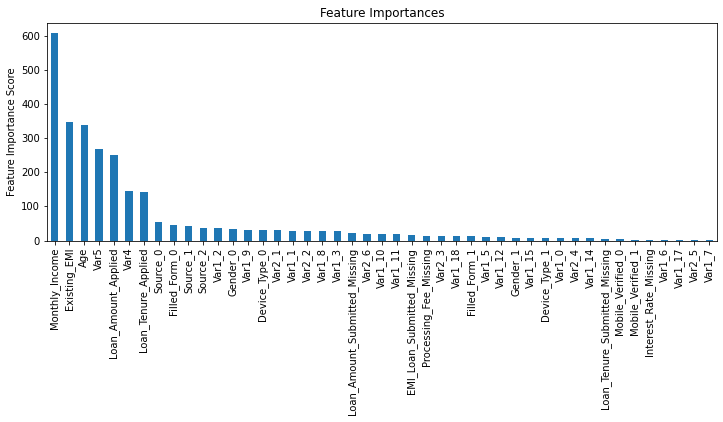

In [0]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=140,
 max_depth=5,
 min_child_weight=0.5,
 gamma=0.3,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.887355
Best Iteration: 125

#Step 6: Reducing Learning Rate
Lastly, we should lower the learning rate and add more trees. Lets use the cv function of XGBoost to do the job again.

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.788873       0.006156       0.785794      0.017887
1          0.801724       0.007518       0.794730      0.015317
2          0.814470       0.005494       0.806025      0.017718
3          0.819200       0.004463       0.810746      0.017574
4          0.820484       0.004167       0.811009      0.017772
..              ...            ...            ...           ...
135        0.907719       0.002021       0.843590      0.012710
136        0.908074       0.002053       0.843438      0.012826
137        0.908290       0.002211       0.843350      0.012976
138        0.908508       0.002192       0.843381      0.013097
139        0.908935       0.002223       0.843416      0.013111

[140 rows x 4 columns]

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.903265
Best Iteration: 139


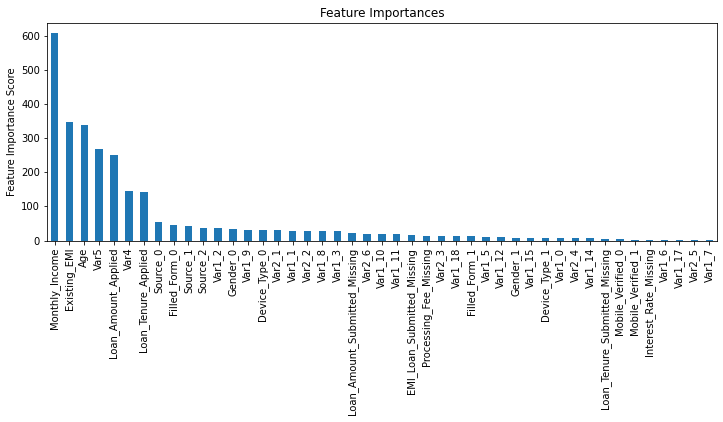

In [0]:
xgb4 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=0.5,
 gamma=0.3,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.001,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, predictors)